In [2]:
from tqdm import tqdm, tqdm_notebook
import pickle

import pandas as pd
import numpy as np

import spacy
from gensim.models import Phrases
from gensim import models,corpora
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis.gensim

from pathlib import Path
from multiprocessing import Pool

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [27]:
import warnings
import logging
warnings.filterwarnings('ignore')

In [3]:
PATH = Path('data/')
list(PATH.iterdir())

[PosixPath('data/train.tsv'), PosixPath('data/test.tsv')]

In [4]:
train_df = pd.read_csv(PATH/'train.tsv',sep = '\t')

In [8]:
test_df = pd.read_csv(PATH/'test.tsv',sep = '\t')

## Processing Descriptions

In [5]:
nlp = spacy.load('en')

### Tokenize Text

In [6]:
def tokenize_text(df_col):
    text_corpus = df_col.apply(lambda x: str(x).lower()).values
    removal=['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET',
             'ADP','SPACE','VERB']
    text_out_final = []

    for review in tqdm_notebook(nlp.pipe(text_corpus, n_threads=24, batch_size=10000),
                                desc='Tokenizing'):
        text_out = []
        for token in review:
            if token.pos_ not in removal and token.is_punct == False and token.is_stop == False:
                lemma = token.lemma_
                if lemma != '-PRON-':
                    text_out.append(lemma)

        text_out_final.append(text_out)
    return text_out_final

In [7]:
tokenized_text = tokenize_text(train_df['item_description'])

A Jupyter Widget

In [9]:
tokenized_text_test = tokenize_text(test_df['item_description'])

A Jupyter Widget

In [12]:
with open('data/tokenized_text_train.pkl', 'wb') as f:
    pickle.dump(tokenized_text, f)

with open('data/tokenized_text_test.pkl', 'wb') as f:
    pickle.dump(tokenized_text_test, f)

In [13]:
review_len_test = [len(x) for x in tokenized_text_test]
review_len = [len(x) for x in tokenized_text]
np.percentile(review_len, 95)

47.0

### Create Bi-grams

In [15]:
bigram_model = Phrases(tokenized_text, scoring='npmi', threshold=0.5, min_count=100)
# what's threshold?
# scoring types, what's the difference
# threshold - number of times the bigram occurs?

In [16]:
def generate_bigrams(review):
    return bigram_model[review]

In [29]:
p = Pool(24)
processed_bigram_descriptions = p.map(generate_bigrams, tokenized_text)

### Build Dictionary and Doc Term Matrix

In [21]:
dictionary = corpora.Dictionary(processed_bigram_descriptions)

In [22]:
doc_term_matrix = p.map(dictionary.doc2bow, processed_bigram_descriptions)

## Topic Modeling

In [30]:
Lda = models.LdaMulticore
coherenceList_umass = []
num_topics_list = np.arange(5,30,5)
for num_topics in tqdm_notebook(num_topics_list):
    lda= Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, 
             passes=3, chunksize=8000, random_state=42)
    cm = CoherenceModel(model=lda, corpus=doc_term_matrix, 
                        dictionary=dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    vis = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
    pyLDAvis.save_html(vis, f'pyLDAvis_{num_topics}.html')
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

A Jupyter Widget

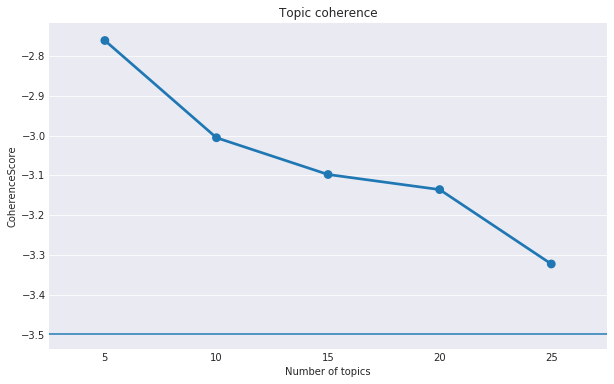

In [35]:
plotData = pd.DataFrame({'Number of topics': num_topics_list,
                         'CoherenceScore': coherenceList_umass})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics', y= 'CoherenceScore', data=plotData)
plt.axhline(y=-3.5)
plt.title('Topic coherence')
plt.show();
plt.savefig('Topic coherence plot.png')